# Part 2: Thermal Wind
Andrew Delman, updated 2025-07-24.

## Objectives

To use ECCO state estimate output to explore thermal wind and its use in understanding the ocean circulation.

By the end of the tutorial, you will be able to:

* Plot transects along lines of latitude in the ECCO native grid
* Rotate fields in model axes to true zonal/meridional orientation
* Relate the density structure to the direction of oceanic flow (thermal wind balance)
* Estimate oceanic velocity using thermal wind and assumption of a level of no motion

## Introduction

In the previous tutorial we established that geostrophic balance explains most of the oceanic circulation--at least at the spatial and temporal scales of ECCOv4r4 output. Now we consider thermal wind, a property of geostrophic flow that has been very useful to atmospheric and ocean scientists alike. Thermal wind balance is derived directly from geostrophic balance (in horizontal directions)

$$
v_g = \frac{1}{f\rho}\frac{\partial{p}}{\partial{x}}
$$
$$
u_g = -\frac{1}{f\rho}\frac{\partial{p}}{\partial{y}}
$$

and hydrostatic balance (in the vertical direction)

$$
\frac{\partial{p}}{\partial{z}} = -{\rho}g
$$

Therefore by differentiating geostrophic balance along the $z$ axis and assuming hydrostatic conditions, we get thermal wind balance:

$$
\frac{\partial{v_g}}{\partial{z}} = -\frac{g}{f\rho}\frac{\partial{\rho}}{\partial{x}}
$$
$$
\frac{\partial{u_g}}{\partial{z}} = \frac{g}{f\rho}\frac{\partial{\rho}}{\partial{y}}
$$

(cf. Vallis ch. 2.8, Kundu and Cohen ch. 14.5, Gill ch. 7.7)

The *thermal wind* name originates from the application of these equations to atmospheric dynamics, where the velocities are the wind and density is mostly a function of temperature. But the balance is just as important to oceanic dynamics. In both the atmosphere and ocean, thermal wind enabled early measurements of temperature (and salinity in the ocean) to be used to construct velocity fields, where velocities are often difficult to measure directly. And even in present times when velocities can be measured directly, the thermal wind relation connects changes in heat and salt content to changes in the ocean circulation.

## Viewing and Plotting Density

### Transect on a single tile

Let's use the density and velocity output datasets from ECCOv4r4 for January 2000, as used in the previous tutorial. This time, we'll focus on ```tile=10```, which is rotated counterclockwise so that the $j$ index increases with increasing longitude (not latitude), and the $i$ index increases with *decreasing* latitude. Tiles 7-12 (the 8th through 13th tiles, remember Python indexing starts at 0) are rotated in this way, as illustrated in the following tile plot

![llc90 tile layout](../figures/llc90_0.png)

For this tutorial, we will need the ECCO datasets with the following ShortNames:

- **ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4** (Jan 2000)
- **ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4** (Jan 2000)
- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4** (no time dimension)

To download these datasets to your local machine, we use `ecco_access`. The `ecco_access` library is included in the `ecco_v4_py` Python package; see the [*ecco_access* intro tutorial](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Importing-ecco_access-to-your-workspace) for instructions on how to set this up. If not working in the AWS cloud, the "access mode" for retrieving the datasets is `download_ifspace` by default, which downloads the data (under `~/Downloads/ECCO_V4r4_PODAAC/`) only if it will occupy <50% of available storage. If it will occupy more than this amount of storage, an error is returned. See the [access modes](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_modes.html) tutorial for more information on these modes.

> Tip: If you are working in the AWS Cloud, you can specify `incloud_access = True`, which will then use mode = `s3_open_fsspec` by default. The `s3_open_fsspec` mode downloads pre-generated `.json` files that essentially act as an index to the data files, greatly speeding up access to them within the AWS Cloud.

We are going to load the density dataset and plot density on longitude-depth axes following the line in the grid nearest to $26^{o}$ N, i.e., ```i = 73```.

In [1]:
# specify incloud_access = True if working in the AWS Cloud, otherwise False
incloud_access = False

from os.path import expanduser,join
user_home_dir = expanduser('~')

if incloud_access:
    access_mode = 's3_open_fsspec'
    download_root_dir = None
    # specify location to store json files that will speed up S3 data access
    jsons_root_dir = join(user_home_dir,'MZZ')
else:
    access_mode = 'download_ifspace'
    # specify location to store downloaded files
    # ~/Downloads/ECCO_V4r4_PODAAC is also the default path used for download_root_dir; 
    # change as needed
    download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
    jsons_root_dir = None

# first import needed packages
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
import sys
import matplotlib.pyplot as plt

import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea
from ecco_po_tutorials import *   # import from ecco_po_tutorials.py module downloaded in the last tutorial


# ShortNames
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"

In [3]:
# now open density and grid parameter files

# density file
ds_dens = ea.ecco_podaac_to_xrdataset(denspress_monthly_shortname,\
                                      StartDate="2000-01",EndDate="2000-01",\
                                      mode=access_mode,\
                                      download_root_dir=download_root_dir,\
                                      jsons_root_dir=jsons_root_dir,\
                                      prompt_request_payer=False)
ds_dens

Size of files to be downloaded to instance is 0.029 GB,
which is 0.02% of the 143.718 GB available storage.
Proceeding with file downloads via NASA Earthdata URLs
DL Progress: 100%|###########################| 1/1 [00:03<00:00,  3.02s/it]

total downloaded: 30.98 Mb
avg download speed: 10.25 Mb/s
Time spent = 3.021937131881714 seconds




<xarray.Dataset> Size: 89MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    RHOAnoma   (time, k, tile, j, i) float32 21MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
    DRHODR     (time, k_l, tile, j, i) float32 21MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
    PHIHYD     (time, k, tile, j, i) float32 21MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
    PHIHYDcR   (time, k, tile, j, i) float32 21MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Density, Stratification, and ...
    uuid:                            166a1992-4182-11eb-82f9-0cc47a3f43f9

In [4]:
# load grid parameters file
ds_grid = ea.ecco_podaac_to_xrdataset(grid_params_shortname,\
                                      mode=access_mode,\
                                      download_root_dir=download_root_dir,\
                                      jsons_root_dir=jsons_root_dir,\
                                      prompt_request_payer=False)

# find index closest to target latitude
lat_target = 26.
target_i = np.argmin(np.abs(ds_grid.YC[10,70,:].values - lat_target))
# the choice of j = 70 above is random, any j index from 0 to 89 will yield the same target_i
target_i

Size of files to be downloaded to instance is 0.008 GB,
which is 0.01% of the 143.689 GB available storage.
Proceeding with file downloads via NASA Earthdata URLs
DL Progress: 100%|###########################| 1/1 [00:01<00:00,  1.90s/it]

total downloaded: 8.57 Mb
avg download speed: 4.51 Mb/s
Time spent = 1.901167869567871 seconds




73

In [5]:
# # define two new functions (also in ecco_po_tutorials module, but shown here for clarity)

# function to create 2 subplots with split depth axes
def depth_two_subplots(horiz_coords,depth_coords,data,k_split,cmap,mask=None,fig=None,axs=None):
    """
    Make 2 subplots with depth on y-axis, for shallow and deeper depths, given parameters:
    horiz_coords: horizontal coordinate, xarray DataArray
    depth_coords: depth_coordinate, xarray DataArray
    data: 2-D xarray DataArray
    k_split: k coordinate to split the plot at, integer
    cmap: string specifying colormap to use
    mask: 2-D boolean (land) mask, optional
    fig: figure object, optional, default is new figure is created
    axs: axes with two subplots oriented vertically, default is they are created
    """
    
    if (fig is None) and (axs is None):
        fig,axs = plt.subplots(2,1,figsize=(10,10))    # subplots for different depths
    elif (fig is None) or (axs is None):
        print("Warning: Only one of fig or axs has been supplied, not both")
    curr_ax = axs[0]
    curr_plot_0 = curr_ax.pcolormesh(horiz_coords,depth_coords[:k_split],\
                                      data.isel(k=np.arange(k_split)),cmap=cmap)                                      
    if mask is not None:
        curr_mask = mask.isel(k=np.arange(k_split))
        plot_mask(horiz_coords,depth_coords[:k_split],curr_mask,ax=curr_ax,color=(0,0,0))
    curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
    curr_ax.set_ylabel('Depth [m]')    
    clim_0 = curr_plot_0.get_clim()
    
    curr_ax = axs[1]
    curr_plot_1 = curr_ax.pcolormesh(horiz_coords,depth_coords[k_split:],\
                                      data.isel(k=np.arange(25,len(depth_coords))),cmap=cmap)                                      
    if mask is not None:
        curr_mask = mask.isel(k=np.arange(25,len(depth_coords)))
        plot_mask(horiz_coords,depth_coords[k_split:],curr_mask,ax=curr_ax,color=(0,0,0))
    curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
    curr_ax.set_ylabel('Depth [m]')
    clim_1 = curr_plot_1.get_clim()
    
    # create shared colorbar for 2 subplots
    new_clim = [np.fmin(clim_0[0],clim_1[0]),np.fmax(clim_0[1],clim_1[1])]
    curr_plot_0.set_clim(new_clim)
    curr_plot_1.set_clim(new_clim)
    fig.colorbar(curr_plot_1,ax=axs[:])
    return fig,axs

# function to scale colormap, coordinating among multiple plots
def cmap_zerocent_scale_multiplots(plot_objs,scale_factor):
    """
    Center colormap at zero and scale relative to existing |maximum| value across multiple plots, 
    given plot objects (as list) and scale_factor, a number of type float.
    Returns new colormap limits as new_clim.
    """
    clim_plots = np.empty((len(plot_objs),2))
    for count,curr_obj in enumerate(plot_objs):
        clim_plots[count,:] = curr_obj.get_clim()
    new_clim = (scale_factor*np.nanmax(np.abs(clim_plots)))*np.array([-1,1])
    for curr_obj in plot_objs:
        curr_obj.set_clim(new_clim)
    return new_clim

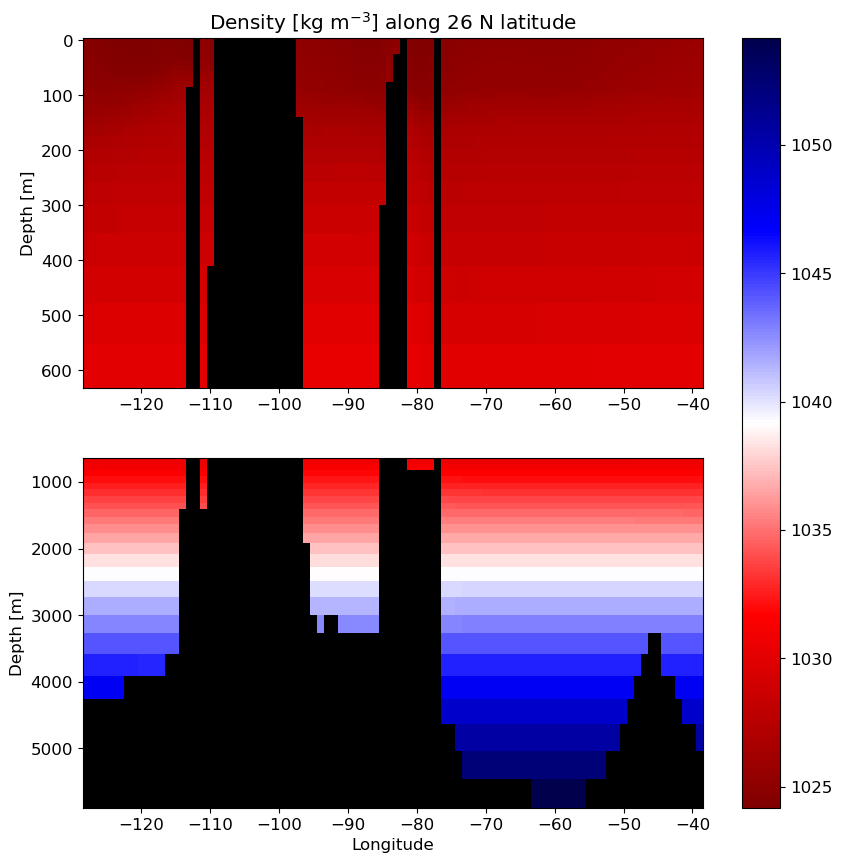

In [6]:
# plot density data along target latitude

# retrieve density field
densanom = ds_dens.RHOAnoma
rhoConst = 1029.
dens = rhoConst + densanom

# load land mask (a boolean array) from grid parameters
land_mask = ~ds_grid.maskC

# plot density along latitude line
tile_plot = 10
i_plot = target_i
# create dictionaries to pass as indices to xarray isel
isel_dict = dict({'tile':tile_plot,'i':i_plot})
isel_dict_ig = dict({'tile':tile_plot,'i_g':i_plot})

plt.rcParams["font.size"] = 12        # set default font size for plots in this tutorial

# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens.isel(isel_dict).squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
                            # '_r' at the end of a colormap name reverses the colormap
axs[0].set_title('Density [kg m$^{-3}$] along 26 N latitude')
axs[1].set_xlabel('Longitude')
plt.show()

### Density anomalies at depth

Notice that in the plots above the density is primarily a function of depth (i.e. pressure). However, thermal wind balance involves horizontal (not vertical) density gradients, and so the density structure that drives the ocean circulation is largely obscured in these plots. One way to look at the horizontal variation of density is to remove a mean density at each depth level; here's what this looks like if we compute the means using only grid cells along this transect:

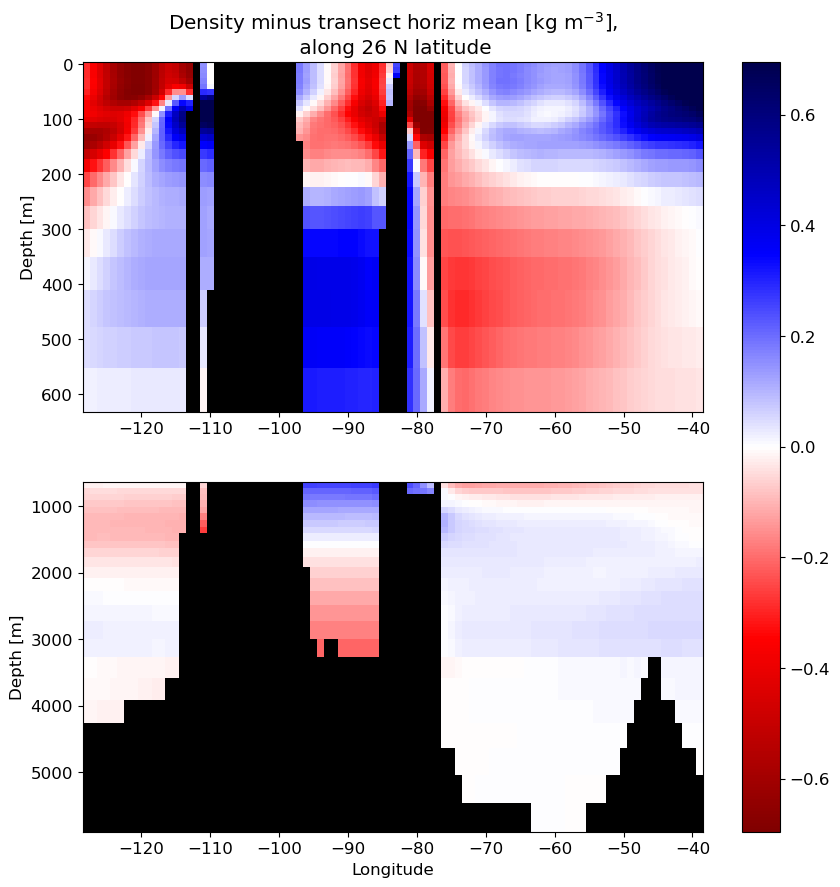

In [7]:
tile_plot = 10
i_plot = target_i
isel_dict = dict({'tile':tile_plot,'i':i_plot})
isel_dict_ig = dict({'tile':tile_plot,'i_g':i_plot})

# compute horizontal density means at each depth level
curr_mask = (~np.isnan((ds_grid.rA*dens)))
dens_mean_atdepth = ((curr_mask*ds_grid.rA*dens).isel(isel_dict).sum("j"))\
                    /((curr_mask*ds_grid.rA).isel(isel_dict).sum("j"))

# anomalies from density means at depth
dens_anom_atdepth = dens.isel(isel_dict) - dens_mean_atdepth


# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens_anom_atdepth.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
axs[0].set_title('Density minus transect horiz mean [kg m$^{-3}$],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

and if we instead remove the global mean at each depth level:

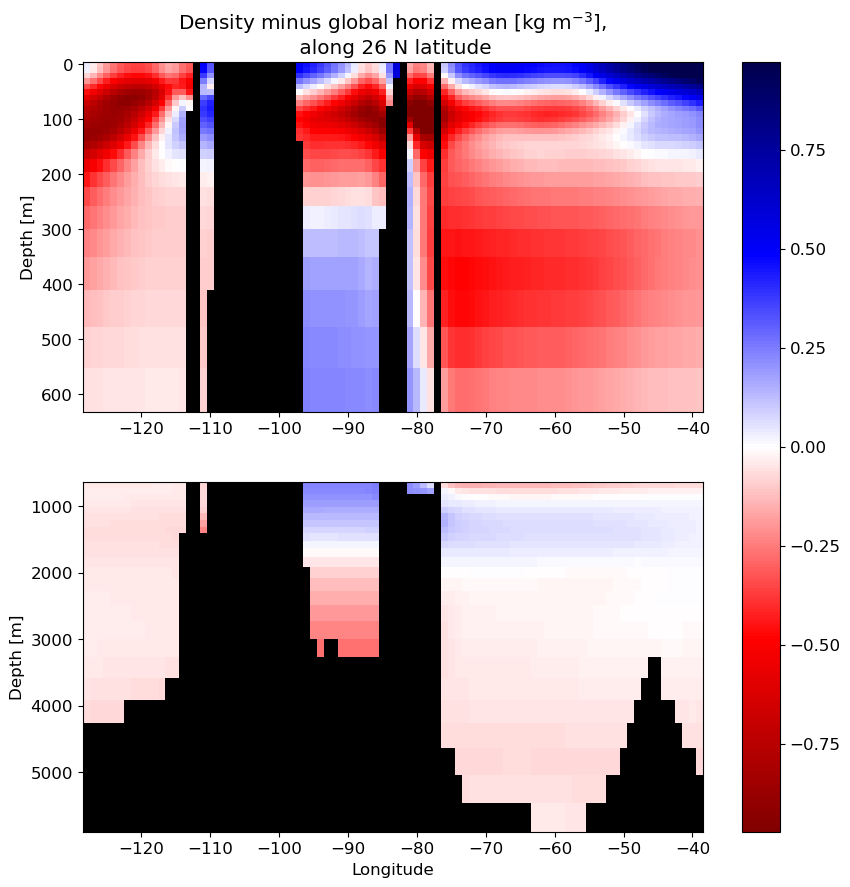

In [8]:
# compute horizontal density means at each depth level
curr_mask = (~np.isnan((ds_grid.rA*dens)))
dens_mean_atdepth = (((curr_mask*ds_grid.rA*dens).sum("tile")).sum("j")).sum("i")\
                    /((((curr_mask*ds_grid.rA).sum("tile")).sum("j")).sum("i"))

# anomalies from density means at depth
dens_anom_atdepth = dens.isel(isel_dict) - dens_mean_atdepth

# make figure
curr_mask = land_mask.isel(isel_dict).squeeze()
fig,axs = depth_two_subplots(ds_grid.XG.isel(isel_dict_ig),-ds_grid.Zl,\
                             dens_anom_atdepth.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=curr_mask)
axs[0].set_title('Density minus global horiz mean [kg m$^{-3}$],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

### Plotting along a line of latitude (multiple tiles)

All the plots above consider a transect in a single tile, but ocean basins generally span multiple tiles of the llc90 grid architecture. In the code below, we define functions to map transects following a line of latitude, across multiple tiles if need be. Then we apply the function to plot density minus horizontal means along the Atlantic 26 N transect.

In [9]:
# # define some functions (these are also in the ecco_po_tutorials.py module)

# define function to take modulus 360, output in a given range
def mod_360_range(n,low_bound):
    "Compute n mod 360; output is in the range [n,n+360)"
    out = ((n - low_bound) % 360) + low_bound
    return out

# define function that searches for and outputs grid indices along line of latitude
def llc_grid_idx_along_lat(lat_transect,lon_bnds):
    """
    Finds grid indices along a given line of latitude.
    Input parameters:
    - lat_transect: line of latitude to plot along, float
    - lon_bnds: 2 elements specifying western and eastern longitude bounds of transect, list or numpy array
                The difference between the bounds must be >0 and <=360
    Outputs:
    - idx_along_lat: grid indices along line of latitude, dict containing 'tile','j','i' as keys
    - XC_along_lat: longitude of grid cell centers, numpy array
    - XG_along_lat: longitude of western grid cell edges, numpy array
    """
    
    # identify indices of grid cells along latitude transect
    mask_along_lat = np.logical_and((ds_grid.YC_bnds > lat_transect).sum("nb") > 0,\
                                    (ds_grid.YC_bnds > lat_transect).sum("nb") < 4)
    mask_in_lon_bnds = np.logical_and((mod_360_range(ds_grid.XC,lon_bnds[1]) > mod_360_range(lon_bnds[0],lon_bnds[1])),\
                                      (mod_360_range(ds_grid.XC,lon_bnds[0]) < mod_360_range(lon_bnds[1],lon_bnds[0] + 1.e-5)))
    mask_along_lat = np.logical_and(mask_along_lat,mask_in_lon_bnds)
    idx_along_lat = mask_along_lat.values.nonzero()
    # create longitude arrays along transect
    XC_along_lat = np.zeros((len(idx_along_lat[0]),))
    XG_along_lat = np.zeros((len(idx_along_lat[0]),))
    # for loop through indices along transect, using zip to iterate through three spatial indices
    for count,(tile_idx,j_idx,i_idx) in enumerate(zip(idx_along_lat[0],idx_along_lat[1],idx_along_lat[2])):
        curr_XC = mod_360_range(ds_grid.XC[tile_idx,j_idx,i_idx],lon_bnds[0])
        XC_along_lat[count] = curr_XC
        XG_along_lat[count] = np.min(mod_360_range(ds_grid.XC_bnds[tile_idx,j_idx,i_idx,:],curr_XC - 180))
    # sort grid cells in order of increasing longitude
    idx_sorted = np.argsort(XC_along_lat)
    XC_along_lat = XC_along_lat[idx_sorted]
    XG_along_lat = XG_along_lat[idx_sorted]
    tile_idx_sorted = idx_along_lat[0][idx_sorted]
    j_idx_sorted = idx_along_lat[1][idx_sorted]
    i_idx_sorted = idx_along_lat[2][idx_sorted]
    idx_along_lat = {'tile':tile_idx_sorted,'j':j_idx_sorted,'i':i_idx_sorted}
    return idx_along_lat,XC_along_lat,XG_along_lat

# define function to retrieve data along latitude transect, given grid indices
def data_along_lat(data_in,idx_along_lat,XC_along_lat,XG_along_lat):
    """
    Creates xarray DataArray along latitude transect, given grid indices
    Input parameters:
    - data_in: data to plot along latitude, xarray DataArray or numpy array
            must have 4 or 5 dimensions, 'time','k','tile','j','i', 'time' is optional
    - XC_along_lat: longitudes of grid cell centers, numpy array
    - XG_along_lat: longitudes of western grid cell edges, numpy array
    Outputs:
    - data_xrarray: data along latitude transect, xarray DataArray
    """
    
    # retrieve grid indices along transect
    tile_idx_along = idx_along_lat['tile']
    j_idx_along = idx_along_lat['j']
    i_idx_along = idx_along_lat['i']
    
    # construct DataArray along transect
    data_along_lat = np.empty(data_in.shape[:-3] + (len(idx_along_lat['i']),))
    data_along_lat.fill(np.nan)
    for count,(tile_idx,j_idx,i_idx) in enumerate(zip(tile_idx_along,j_idx_along,i_idx_along)):
        if len(data_in.shape) == 4:
            data_along_lat[:,count] = data_in[:,tile_idx,j_idx,i_idx]
        elif len(data_in.shape) == 5:
            data_along_lat[:,:,count] = data_in[:,:,tile_idx,j_idx,i_idx]
    if len(data_in.shape) == 4:    # no time dimension
        data_xrarray = xr.DataArray(
                    data=data_along_lat,
                    dims=["k","lon"],
                    coords=dict(
                        Z=(["k"],ds_grid.Z.data),
                        lon=(["lon"],XC_along_lat),
                        lonW=(["lon"],XG_along_lat),
                        lat=lat_transect,
                    ),
        )
    elif len(data_in.shape) == 5:    # include time dimension
        try:
            time_coord = data_in.time.data
        except:
            time_coord = np.nan
        data_xrarray = xr.DataArray(
                    data=data_along_lat,
                    dims=["time","k","lon"],
                    coords=dict(
                        time=(["time"],time_coord),
                        Z=(["k"],ds_grid.Z.data),
                        lon=(["lon"],XC_along_lat),
                        lonW=(["lon"],XG_along_lat),
                        lat=lat_transect,
                    ),
        )
    
    return data_xrarray    
    
    
# define function to extract data along line of latitude
def lon_depth_along_lat(lat_transect,lon_bnds,data_in):
    """
    Function to extract data along line of latitude.
    Input parameters:
    - lat_transect: line of latitude to plot along, float
    - lon_bnds: 2 elements specifying western and eastern longitude bounds of transect, list or numpy array
    - data_in: data, numpy array or xarray DataArray
    Outputs:
    - XC_along_lat: longitude of grid cell centers, numpy array
    - XG_along_lat: longitude of western grid cell edges, numpy array
    - data_xrarray: data along latitude transect, xarray DataArray
    """
    
    # identify indices of grid cells along latitude transect
    idx_along_lat,XC_along_lat,XG_along_lat = llc_grid_idx_along_lat(lat_transect,lon_bnds)
    
    # construct DataArray along transect
    data_xrarray = data_along_lat(data_in,idx_along_lat,XC_along_lat,XG_along_lat)
    
    return XC_along_lat,XG_along_lat,data_xrarray

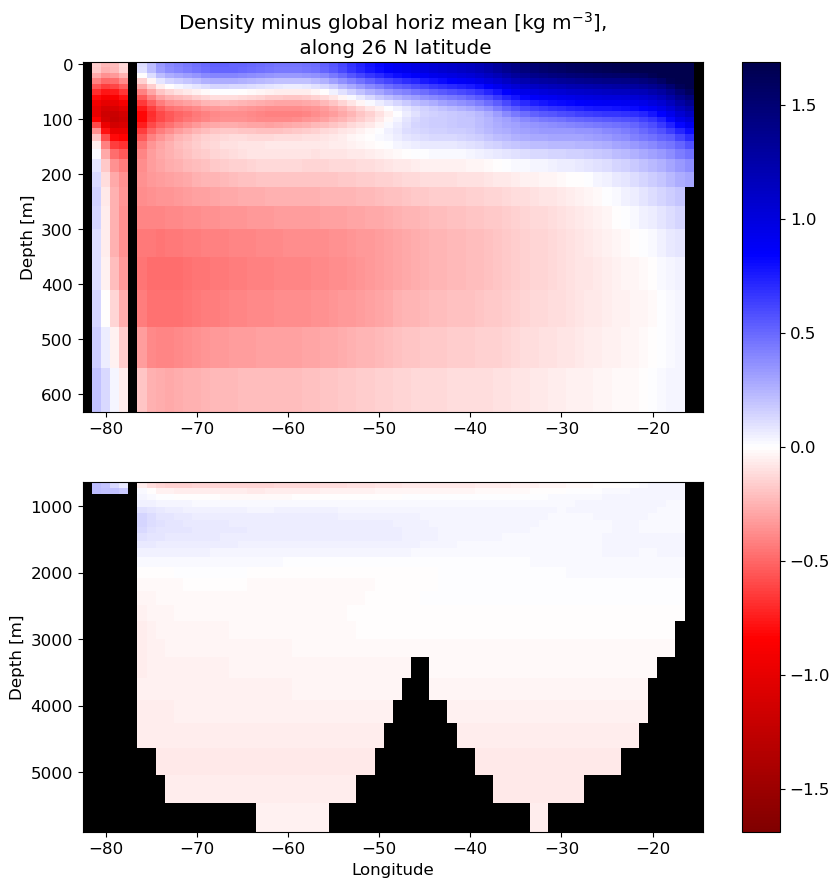

In [10]:
# create data array along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]
XC_transect,XG_transect,mask_transect = lon_depth_along_lat(lat_transect,lon_bnds,land_mask)
XC_transect,XG_transect,dens_transect = lon_depth_along_lat(lat_transect,lon_bnds,dens)

# anomalies from density means at depth
dens_anom_transect = dens_transect - np.expand_dims(dens_mean_atdepth,axis=-1)

# make figure
fig,axs = depth_two_subplots(XG_transect,-ds_grid.Zl,\
                             dens_anom_transect.squeeze(),\
                             k_split=25,cmap='seismic_r',mask=mask_transect)
axs[0].set_title('Density minus global horiz mean [kg m$^{-3}$],\n along 26 N latitude')
axs[1].set_xlabel('Longitude')
plot_objs = [axs[0].get_children()[0],axs[1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.8)

plt.show()

## Computing thermal wind balance

### Thermal wind balance across Atlantic (26 N)

Now let's compute horizontal density gradients (times $g/f$) and compare with vertical velocity gradients---i.e., thermal wind balance. This calculation is complicated by the fact that density, $u$ and $v$ all start out at different positions on each grid cell, and that we take differences in both horizontal and vertical directions. To enable this to be done so that both sides of the equations end up on the same points in the grid, the calculations are done in the following order:

* Density at center of grid cells (i,j,k) --horiz difference-->
    * Horizontal density gradients at edge of grid cells (i_g,j,k) or (i,j_g,k) --horiz interpolate-->
        * Interpolated horizontal density gradients (i,j,k)


* $u$,$v$ at edge of grid cells (i_g,j,k) or (i,j_g,k) --horiz interpolate-->
    * Centered $u$,$v$ (i,j,k) --vert difference-->
        * Vertical $u$,$v$ gradients (i,j,k_l) --vert interpolate-->
            * Interpolated $u$,$v$ gradients (i,j,k)

Then we rotate velocities and gradients from model axes to geographical (zonal and meridional) axes. Finally, we apply the *lon_depth_along_lat* function used above to look at the thermal wind balance across the Atlantic basin.   

In [11]:
# get xgcm Grid object for ECCO LLC90 grid
xgcm_grid = ecco.get_llc_grid(ds_grid)

In [12]:
g = 9.81
# compute f from latitude of grid cell centers
lat = ds_grid.YC
Omega = (2*np.pi)/86164
lat_rad = (np.pi/180)*lat    # convert latitude from degrees to radians
# expand dimensions so that f broadcasts correctly across DataArrays
f = np.expand_dims(2*Omega*np.sin(lat_rad),axis=(0,1))

# convert dens DataArray data from dask to numpy array
dens = dens.compute()

# compute derivatives of density in x and y
d_rho_dx = (xgcm_grid.diff(dens,axis="X",boundary='extend'))/ds_grid.dxC
d_rho_dy = (xgcm_grid.diff(dens,axis="Y",boundary='extend'))/ds_grid.dyC
d_rho_dx = d_rho_dx.compute()
d_rho_dy = d_rho_dy.compute()

# interpolate (vector) gradient values to center of grid cells
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    # use this to ignore future warnings caused by interp_2d_vector function
    rho_grads_interp = xgcm_grid.interp_2d_vector({"X":d_rho_dx,"Y":d_rho_dy},boundary='extend')
d_rho_dx = rho_grads_interp['X']
d_rho_dy = rho_grads_interp['Y']
d_rho_dx.name = 'drho_dx'
d_rho_dy.name = 'drho_dy'

# rotate from model to geographical (lon-lat) axes
CS = np.expand_dims(ds_grid.CS,axis=(0,1))
SN = np.expand_dims(ds_grid.SN,axis=(0,1))
d_rho_zonal = (CS*d_rho_dx) - (SN*d_rho_dy)
d_rho_merid = (SN*d_rho_dx) + (CS*d_rho_dy)

# right-hand side of thermal wind balance equations
therm_wind_RHS_1 = -(g/(f*dens))*d_rho_zonal
therm_wind_RHS_2 = (g/(f*dens))*d_rho_merid

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [13]:
# load velocity dataset
ds_vel = ea.ecco_podaac_to_xrdataset(vel_monthly_shortname,\
                                     StartDate='2000-01',EndDate='2000-01',\
                                     mode=access_mode,\
                                     download_root_dir=download_root_dir,\
                                     jsons_root_dir=jsons_root_dir,\
                                     prompt_request_payer=False)

Size of files to be downloaded to instance is 0.029 GB,
which is 0.02% of the 143.681 GB available storage.
Proceeding with file downloads via NASA Earthdata URLs
DL Progress: 100%|###########################| 1/1 [00:02<00:00,  2.55s/it]

total downloaded: 30.6 Mb
avg download speed: 11.98 Mb/s
Time spent = 2.553600788116455 seconds




In [14]:
# interpolate velocities to center of grid cells
UVEL = ds_vel.UVEL.compute()
VVEL = ds_vel.VVEL.compute()
UVEL.values[np.isnan(UVEL.values)] = 0
VVEL.values[np.isnan(VVEL.values)] = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vel_interp = xgcm_grid.interp_2d_vector({'X':UVEL,'Y':VVEL},boundary='extend')
u = vel_interp['X']
v = vel_interp['Y']

# vertical derivatives of velocity 
# (negative sign after = because z increases upward, while k indices decrease upward)
du_dz_gridedge = -(u.diff("k").values)/np.expand_dims(ds_grid.drC[1:-1].values,axis=(0,2,3,4))
dv_dz_gridedge = -(v.diff("k").values)/np.expand_dims(ds_grid.drC[1:-1].values,axis=(0,2,3,4))

# vertical interpolation of du/dz, dv/dz
du_dz = np.empty(u.shape)
du_dz.fill(np.nan)    # fill empty numpy array with NaNs
dv_dz = np.empty(v.shape)
dv_dz.fill(np.nan)
du_dz[:,1:-1,:,:,:] = du_dz_gridedge[:,1:,:,:,:] - (np.diff(du_dz_gridedge,axis=1)/2)
dv_dz[:,1:-1,:,:,:] = dv_dz_gridedge[:,1:,:,:,:] - (np.diff(dv_dz_gridedge,axis=1)/2)
# create xarray DataArrays
du_dz_array = xr.DataArray(
                data=du_dz,
                dims=["time","k","tile","j","i"],
                coords=u.coords,
)
dv_dz_array = xr.DataArray(
                data=dv_dz,
                dims=["time","k","tile","j","i"],
                coords=v.coords,
)

# rotate from model to geographical (lon-lat) axes
du_dz_zonal = (CS*du_dz_array) - (SN*dv_dz_array)
dv_dz_merid = (SN*du_dz_array) + (CS*dv_dz_array)

# left-hand side of thermal wind balance equations
therm_wind_LHS_1 = dv_dz_merid
therm_wind_LHS_2 = du_dz_zonal

In [15]:
# generate DataArrays along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]

# use llc_grid_idx_along_lat and data_along_lat functions separately (runs faster)

idx_along_lat,XC_transect,XG_transect = llc_grid_idx_along_lat(lat_transect,lon_bnds)

mask_transect = data_along_lat(land_mask,idx_along_lat,XC_transect,XG_transect)
tw_LHS_1_transect = data_along_lat(therm_wind_LHS_1,idx_along_lat,XC_transect,XG_transect)
tw_LHS_2_transect = data_along_lat(therm_wind_LHS_2,idx_along_lat,XC_transect,XG_transect)
tw_RHS_1_transect = data_along_lat(therm_wind_RHS_1,idx_along_lat,XC_transect,XG_transect)
tw_RHS_2_transect = data_along_lat(therm_wind_RHS_2,idx_along_lat,XC_transect,XG_transect)

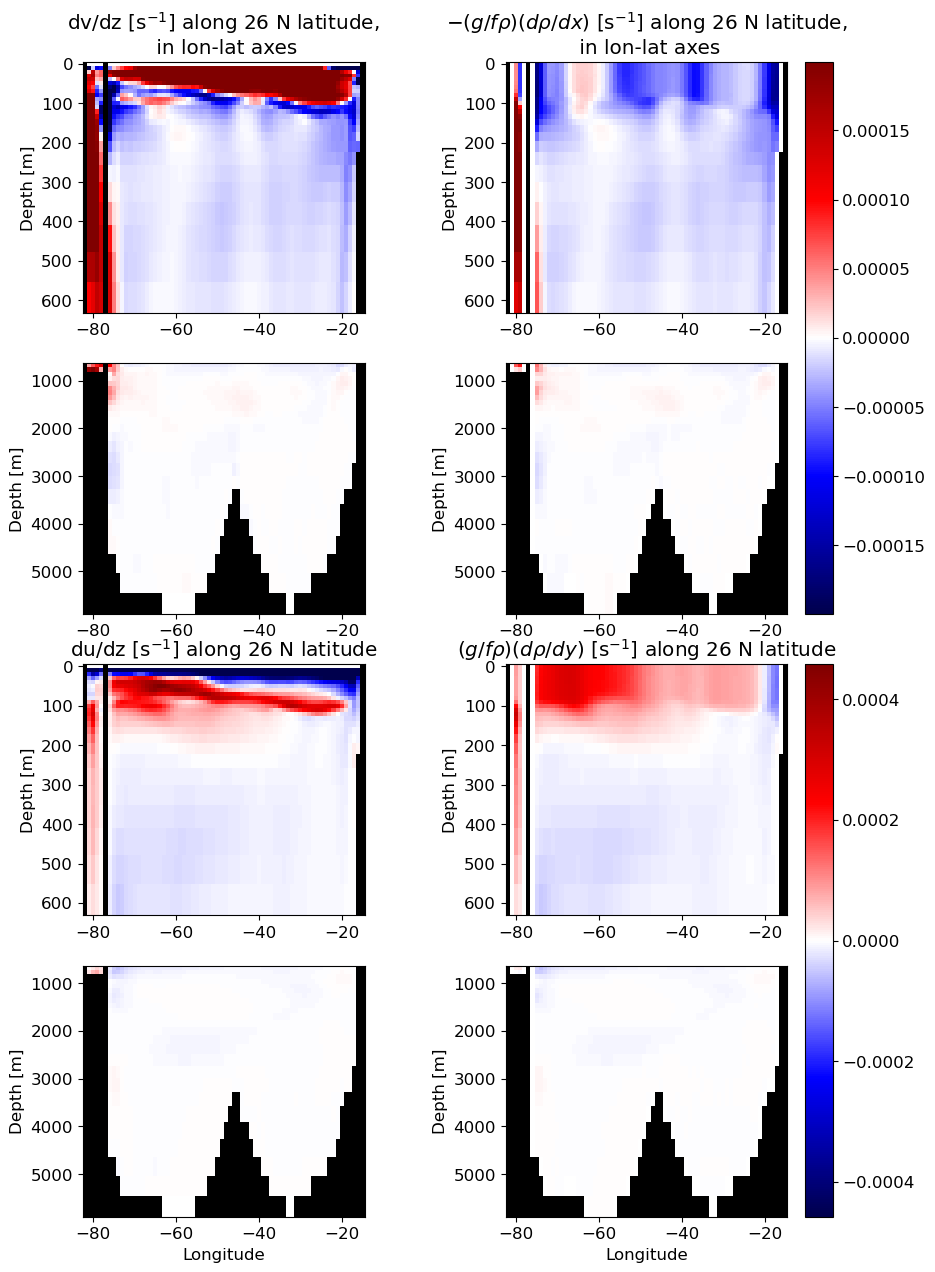

In [16]:
# make figure
plt.rcParams["font.size"] = 12   # change font size
fig,axs = plt.subplots(4,2,figsize=(10,15))
depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_LHS_1_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,0])
axs[0,0].set_title('dv/dz [s$^{-1}$] along 26 N latitude,\n in lon-lat axes')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_RHS_1_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,1])
axs[0,1].set_title('$-(g/f\\rho)(d\\rho/dx)$ [s$^{-1}$] along 26 N latitude,\n in lon-lat axes')
plot_objs = [axs[0,0].get_children()[0],axs[1,0].get_children()[0],\
             axs[0,1].get_children()[0],axs[1,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.2)

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_LHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,0])
axs[2,0].set_title('du/dz [s$^{-1}$] along 26 N latitude')
axs[3,0].set_xlabel('Longitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     tw_RHS_2_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,1])
axs[2,1].set_title('$(g/f\\rho)(d\\rho/dy)$ [s$^{-1}$] along 26 N latitude')
axs[3,1].set_xlabel('Longitude')
plot_objs = [axs[2,0].get_children()[0],axs[3,0].get_children()[0],\
             axs[2,1].get_children()[0],axs[3,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.2)

# remove colorbars from left column plots (to declutter figure)
fig.get_children()[-4].remove()
fig.get_children()[-2].remove()

plt.show()

Note that the plots in the left and right columns are very similar at depths below ~100 meters, and very different in the top 100 meters. Why do you think this is?

### Velocity reconstruction using thermal wind

In early studies of the atmosphere and ocean, measuring in-situ velocities accurately was nearly impossible, but properties such as temperature, humidity, and salinity (that are closely related to density) could be more readily observed. Even in present-day observing systems such as atmospheric radiosondes and oceanic Argo floats, observing the density structure can tell us a lot about the movement of the fluid, because of the application of thermal wind balance.

Given the thermal wind balance equations introduced earlier, integrating vertically between two depth levels $z = z_0$ and $z = z_1$ gives us

$$
v_g(z_1) - v_g(z_0) = -\frac{g}{f}\int_{z_0}^{z_1} \frac{1}{\rho}\frac{\partial{\rho}}{\partial{x}}\, dz
$$

$$
u_g(z_1) - u_g(z_0) = \frac{g}{f}\int_{z_0}^{z_1} \frac{1}{\rho}\frac{\partial{\rho}}{\partial{y}}\, dz
$$

Since velocities in the deep ocean tend to be much smaller than those near the surface, a common technique used in oceanography has been to assume a *level of no motion*, i.e., let $u_g(z_0) = v_g(z_0) = 0$. Then upper ocean geostrophic velocities can be inferred from vertical profiles of density, spaced at regular intervals. Here we can assess the accuracy of this technique using ECCO v4r4 output.

## Assessment

### Thermal wind-based velocity reconstruction

Let's integrate geostrophic velocity from a depth level where we assume the velocity is zero (even though we know from ECCO output that the velocity will not be exactly zero). In this example we'll take the level of no motion to be 3000 meters depth. Then we consider the result of this velocity reconstruction along the Atlantic 26 N transect we just considered.

In [17]:
# set level of no motion
z_0 = -3000.

# integrate (sum) RHS of thermal wind balance upward
ds_grid['Zl'] = ds_grid.Zl.compute()
dist_z0_upper = ds_grid.Zl - z_0
dist_z0_upper[ds_grid.Zl < z_0] = 0
delta_upper = (-dist_z0_upper.diff("k_l")).values
delta_upper = np.concatenate((delta_upper,np.array([0,])))
delta_upper = np.expand_dims(delta_upper,axis=(0,2,3,4))
v_g_reconstr_upward = (((delta_upper*therm_wind_RHS_1)\
                       .sel(k=slice(None,None,-1)))\
                        .cumsum(dim="k",skipna=True))\
                        .sel(k=slice(None,None,-1))    # slice object "flips" array along k dimension
u_g_reconstr_upward = (((delta_upper*therm_wind_RHS_2)\
                       .sel(k=slice(None,None,-1)))\
                        .cumsum(dim="k",skipna=True))\
                        .sel(k=slice(None,None,-1))    # slice object "flips" array along k dimension
# interpolate DataArrays to center of tracer cells
v_g_reconstr_upward_interp = v_g_reconstr_upward
v_g_reconstr_upward_interp.isel(k=np.arange(0,len(ds_grid.k) - 1)).values = \
                            v_g_reconstr_upward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                            + ((v_g_reconstr_upward.diff("k").values)/2)
u_g_reconstr_upward_interp = u_g_reconstr_upward
u_g_reconstr_upward_interp.isel(k=np.arange(0,len(ds_grid.k) - 1)).values = \
                            u_g_reconstr_upward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                            + ((u_g_reconstr_upward.diff("k").values)/2)

# integrate (sum) RHS of thermal wind balance downward
ds_grid['Zu'] = ds_grid.Zu.compute()
dist_z0_lower = ds_grid.Zu - z_0
dist_z0_lower[ds_grid.Zu > z_0] = 0
delta_lower = (-dist_z0_lower.diff("k_u")).values
delta_lower = np.concatenate((np.array([0,]),delta_lower))
delta_lower = np.expand_dims(delta_lower,axis=(0,2,3,4))
v_g_reconstr_downward = (delta_lower*therm_wind_RHS_1)\
                       .cumsum(dim="k",skipna=True)
u_g_reconstr_downward = (delta_lower*therm_wind_RHS_2)\
                        .cumsum(dim="k",skipna=True)
v_g_reconstr_downward_interp = v_g_reconstr_downward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                                + ((v_g_reconstr_downward.diff("k").values)/2)
v_g_reconstr_downward_interp = v_g_reconstr_downward_interp.pad(k=(1,0),constant_value=0)
u_g_reconstr_downward_interp = u_g_reconstr_downward.isel(k=np.arange(0,len(ds_grid.k) - 1))\
                                + ((u_g_reconstr_downward.diff("k").values)/2)
u_g_reconstr_downward_interp = u_g_reconstr_downward_interp.pad(k=(1,0),constant_value=0)

# combine results from upward and downward integration
v_g_reconstr = v_g_reconstr_upward_interp
v_g_reconstr.values[:,v_g_reconstr.Z.values < z_0,:,:,:] = \
                                v_g_reconstr_downward_interp.values[:,v_g_reconstr.Z.values < z_0,:,:,:]
u_g_reconstr = u_g_reconstr_upward_interp
u_g_reconstr.values[:,u_g_reconstr.Z.values < z_0,:,:,:] = \
                                u_g_reconstr_downward_interp.values[:,u_g_reconstr.Z.values < z_0,:,:,:]

# rotate (actual) velocities from model to geographical axes
u_zonal = (CS*u) - (SN*v)
v_merid = (SN*u) + (CS*v)

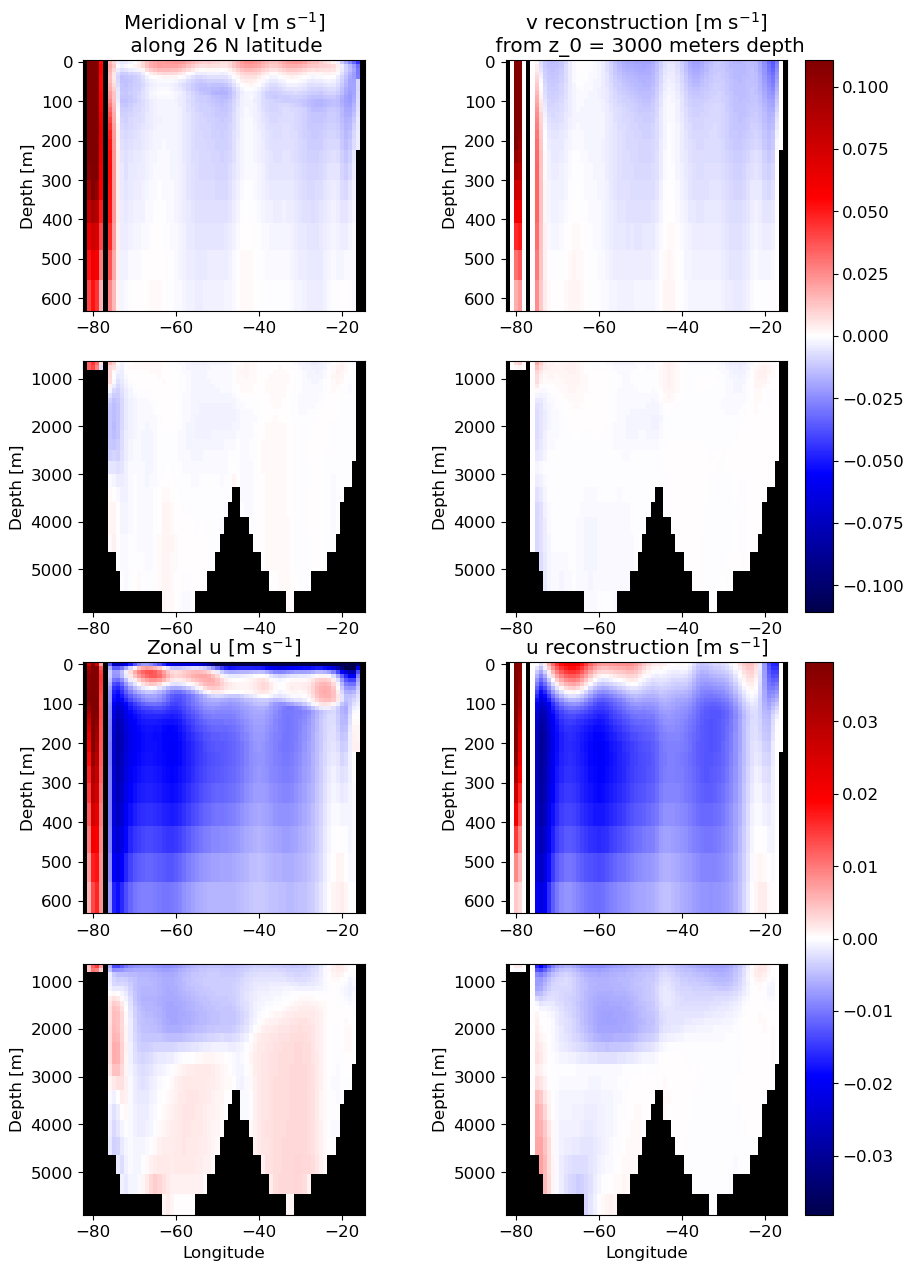

In [18]:
# generate DataArrays along line of latitude
lat_transect = 26.
Atl_W_bound = -82.
Atl_E_bound = -14.
lon_bnds = [Atl_W_bound,Atl_E_bound]

# # only need this line uncommented if new transect is specified above
# idx_along_lat,XC_transect,XG_transect = llc_grid_idx_along_lat(lat_transect,lon_bnds)

mask_transect = data_along_lat(land_mask,idx_along_lat,XC_transect,XG_transect)
u_zonal_transect = data_along_lat(u_zonal,idx_along_lat,XC_transect,XG_transect)
v_merid_transect = data_along_lat(v_merid,idx_along_lat,XC_transect,XG_transect)
u_g_reconstr_transect = data_along_lat(u_g_reconstr,idx_along_lat,XC_transect,XG_transect)
v_g_reconstr_transect = data_along_lat(v_g_reconstr,idx_along_lat,XC_transect,XG_transect)

# make figure
plt.rcParams["font.size"] = 12   # change font size
fig,axs = plt.subplots(4,2,figsize=(10,15))
depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     v_merid_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,0])
axs[0,0].set_title('Meridional v [m s$^{-1}$]\n along 26 N latitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     v_g_reconstr_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[:2,1])
axs[0,1].set_title('v reconstruction [m s$^{-1}$]\n from z_0 = ' + str(int(-z_0)) + ' meters depth')
plot_objs = [axs[0,0].get_children()[0],axs[1,0].get_children()[0],\
             axs[0,1].get_children()[0],axs[1,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.5)

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     u_zonal_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,0])
axs[2,0].set_title('Zonal u [m s$^{-1}$]')
axs[3,0].set_xlabel('Longitude')

depth_two_subplots(XG_transect,-ds_grid.Zl,\
                     u_g_reconstr_transect.squeeze(),\
                     k_split=25,cmap='seismic',mask=mask_transect,\
                      fig=fig,axs=axs[2:,1])
axs[2,1].set_title('u reconstruction [m s$^{-1}$]')
axs[3,1].set_xlabel('Longitude')
plot_objs = [axs[2,0].get_children()[0],axs[3,0].get_children()[0],\
             axs[2,1].get_children()[0],axs[3,1].get_children()[0]]
cmap_zerocent_scale_multiplots(plot_objs,0.5)

# remove colorbars from left column plots (to declutter figure)
fig.get_children()[-4].remove()
fig.get_children()[-2].remove()

plt.show()

### Latitude and depth dependence

Now as we did with geostrophic balance in the previous tutorial, we can compute the normalized difference over the global domain, sorted into bins by latitude and depth. **Note: the ```mean_weighted_binned``` function may take a few minutes to run over the global domain.**

In [19]:
u_diff = u_zonal - u_g_reconstr
v_diff = v_merid - v_g_reconstr
vel_diff_complex = u_diff + (1j*v_diff)    # in Python, imaginary number i is indicated by 1j
vel_complex = u_zonal + (1j*v_merid)

# normalize magnitude of difference vector by magnitude of actual velocity
vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)
vel_diff_norm = vel_diff_abs/vel_abs

# bins of latitude
lat_bin_spacing = 2
lat_bin_bounds = np.c_[-90:90:lat_bin_spacing] + np.array([[0,lat_bin_spacing]])
lat_bin_centers = np.mean(lat_bin_bounds,axis=-1)

# bins of depth
depth_bin_bounds = -ds_grid.Z_bnds.values


# apply "small velocity" mask as in geostrophic balance tutorial
mask_threshold = 0.005    # mask out velocities <0.5 cm s-1
mask_smallvel = (vel_abs < mask_threshold)
curr_weighting = ((~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values

# create depth array that will broadcast correctly across horizontal dimensions
depth_expand_dims = np.expand_dims(-ds_grid.Z,axis=(-3,-2,-1))

# compute normalized differences
diff_norm_lat = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                    ds_grid.YC.values,lat_bin_bounds)
diff_norm_depth = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                    depth_expand_dims,depth_bin_bounds)

# apply additional masks for depth (100-1000 m) and latitude (>5 deg from equator) ranges

depth_mask = np.logical_and(depth_expand_dims > 100,\
                            depth_expand_dims < 1000)
lat_mask = np.expand_dims((np.abs(ds_grid.YC) > 5),axis=0)


# compute norm diff with additional masks

curr_weighting = (depth_mask*(~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values
diff_norm_lat_moremask = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                                ds_grid.YC.values,lat_bin_bounds)

curr_weighting = (lat_mask*(~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values
diff_norm_depth_moremask = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                                depth_expand_dims,depth_bin_bounds)

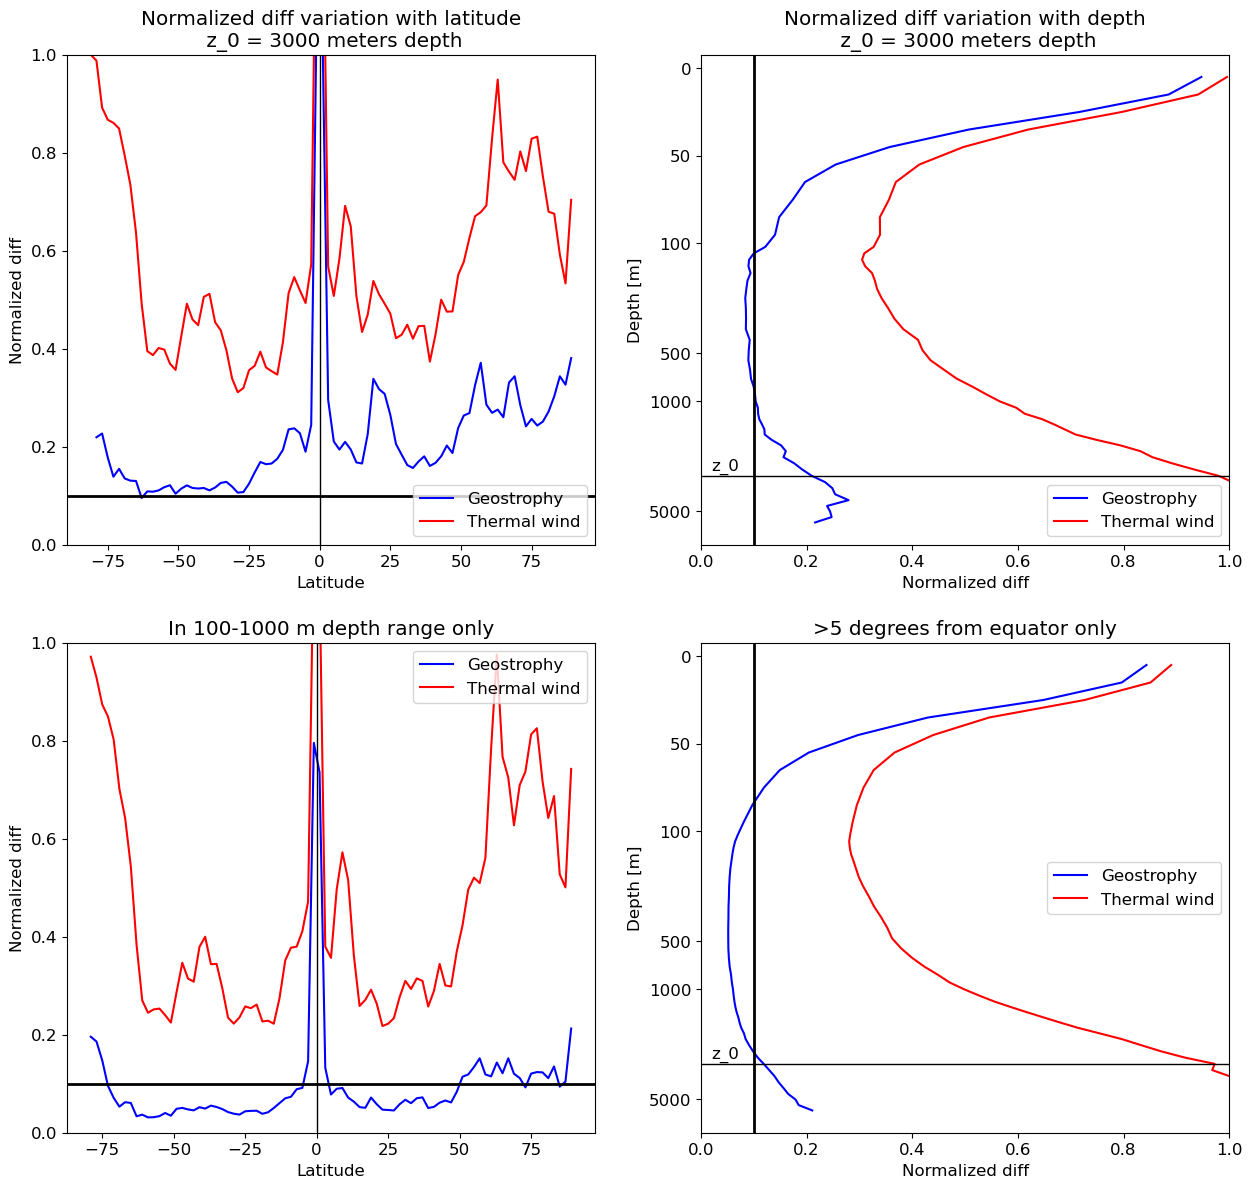

In [20]:
# load norm diff from previous geostrophic balance tutorial
# (if you don't have this file run that tutorial,
# or else comment out the lines containing geostr_file below)
geostr_file = np.load('diff_norm_geostr_bal.npz')

# plot normalized RMS difference, alongside values for geostrophic balance
fig,axs = plt.subplots(2,2,figsize=(15,14))
curr_ax = axs[0,0]
curr_ax.plot(lat_bin_centers,geostr_file['diff_norm_lat'],color='blue',label='Geostrophy')
curr_ax.plot(lat_bin_centers,diff_norm_lat,color='red',label='Thermal wind')
curr_ax.set_ylim(0,1)
curr_ax.axhline(y=0.1,color='black',lw=2)
curr_ax.axvline(x=0,color='black',lw=1)
curr_ax.set_xlabel('Latitude')
curr_ax.set_ylabel('Normalized diff')
curr_ax.set_title('Normalized diff variation with latitude\n z_0 = ' + str(int(-z_0)) + ' meters depth')
curr_ax.legend()
curr_ax = axs[0,1]
curr_ax.plot(geostr_file['diff_norm_depth'],-ds_grid.Z,color='blue',label='Geostrophy')
curr_ax.plot(diff_norm_depth,-ds_grid.Z,color='red',label='Thermal wind')
# Note: in older versions of Matplotlib
# may need to use linthreshy instead of linthresh
curr_ax.set_yscale('symlog',linthresh=100)
curr_ax.invert_yaxis()
curr_ax.axvline(x=0.1,color='black',lw=2)
curr_ax.axhline(y=-z_0,color='black',lw=1)
curr_ax.text(0.02,-0.92*z_0,'z_0')
curr_ax.set_yticks([0,50,100,500,1000,5000])
curr_ax.set_yticklabels(['0','50','100','500','1000','5000'])
curr_ax.set_xlim(0,1)
curr_ax.set_xlabel('Normalized diff')
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('Normalized diff variation with depth\n z_0 = ' + str(int(-z_0)) + ' meters depth')
curr_ax.legend()
curr_ax = axs[1,0]
curr_ax.plot(lat_bin_centers,geostr_file['diff_norm_lat_moremask'],color='blue',label='Geostrophy')
curr_ax.plot(lat_bin_centers,diff_norm_lat_moremask,color='red',label='Thermal wind')
curr_ax.set_ylim(0,1)
curr_ax.axhline(y=0.1,color='black',lw=2)
curr_ax.axvline(x=0,color='black',lw=1)
curr_ax.set_xlabel('Latitude')
curr_ax.set_ylabel('Normalized diff')
curr_ax.set_title('In 100-1000 m depth range only')
curr_ax.legend()
curr_ax = axs[1,1]
curr_ax.plot(geostr_file['diff_norm_depth_moremask'],-ds_grid.Z,color='blue',label='Geostrophy')
curr_ax.plot(diff_norm_depth_moremask,-ds_grid.Z,color='red',label='Thermal wind')
# Note: in older versions of Matplotlib
# may need to use linthreshy instead of linthresh
curr_ax.set_yscale('symlog',linthresh=100)
curr_ax.invert_yaxis()
curr_ax.axvline(x=0.1,color='black',lw=2)
curr_ax.axhline(y=-z_0,color='black',lw=1)
curr_ax.text(0.02,-0.92*z_0,'z_0')
curr_ax.set_yticks([0,50,100,500,1000,5000])
curr_ax.set_yticklabels(['0','50','100','500','1000','5000'])
curr_ax.set_xlim(0,1)
curr_ax.set_xlabel('Normalized diff')
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('>5 degrees from equator only')
curr_ax.legend()

plt.show()

Comparing the geostrophy and thermal wind normalized differences provides some insight into the challenges of reconstructing velocity fields using thermal wind. Geostrophic balance is a more accurate predictor of velocity than thermal wind, since thermal wind assumes: 

* geostrophic balance
* hydrostatic balance (not a factor here since hydrostatic balance is actually assumed in the model code itself)
* a level of no motion (a potentially more problematic assumption, especially close to $z_0$).

The plots above also illustrate why satellite observations of sea surface height are so valuable to oceanographers. Prior to reliable measurements of sea surface height, ocean velocity fields were typically reconstructed using density profiles and thermal wind. When sea surface height data are *combined* with density profiles, we can compute subsurface pressure gradients, and then obtain velocity estimates using only geostrophy, which is much more accurate than having to rely on thermal wind.

## Exercises

1. Try out different values of $z_0$ (i.e., level of no motion) to use in the velocity reconstructions. How does this affect the normalized differences in the plots above? Which $z_0$ values permit the most accurate reconstructions (lowest normalized difference) at 100 meters depth? (For bonus points, write some code to determine the optimal $z_0$ value that minimizes normalized difference at 100 m depth, rather than using trial and error.)

1. Adapt the ```lon_depth_along_lat``` function (and the two functions it calls: ```llc_grid_idx_along_lat``` and ```data_along_lat```) to plot transects following lines of longitude instead of latitude. Use this to look at the application of thermal wind to reconstruct velocities through Drake Passage (~64 deg W, 55-65 deg S).

## References

Gill, A.E. (1982). ***Atmosphere-Ocean Dynamics***. Academic Press, Elsevier.

Kundu, P.K. and Cohen, I.M. (2008). ***Fluid Mechanics*** (4th ed.). Elsevier.

Vallis, G.K. (2006). ***Atmospheric and Oceanic Fluid Dynamics***. Cambridge University Press.